# Reservoir parameterization Hanasaki et al 2006 for mizuRoute


Based on: 
Hanasaki, N., Kanae, S., & Oki, T. (2006). A reservoir operation scheme for global river routing models. Journal of Hydrology, 327(1–2), 22–41. https://doi.org/10.1016/j.jhydrol.2005.11.011

by Shervan Gharari based on the code by Inne Vanderkelen - January 2021

In [37]:
# load the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [38]:
# constants
secperday   = 86400
secperhour  = 3600
dt          = 86400 # time of the modeling can be also hourly for mizuRoute
daypermonth = 30 # average day in a month

In [39]:
# control file flags that should be set to true or T
Hanasaki_model   = True # identifies that the Hanasaki model is called at least once in the river network topoloty
Water_management = False # if the hanasaki lake flag Par_flag_D is true then this should be true in the
# control file and the second nc file containting the water magement should be pass to mizuRoute or through
# coupler (when fully develop) any case the lake formualtion expect the demand values of that time steps


In [40]:
# river network topology variables and parameters
# config in the river network topology alog the paraemters a lake type varibale should be specified
# for Hanasaki this is 2 (for Doll it is 1); it tells which parameteric model the model should follow
# for a given lake
lake_model_type  = 2 # Hanasaki; this is not used here for this code just to calrify
Par_flag_purpose = True # true agricultur; false others
Par_flag_I       = False # false use paraemter always, True transition from parameters to 
Par_flag_D       = False # false use paraemter always, True transition from parameters to

In [64]:
def Hanasaki (# Hanasaki inputs
              S, #storage at the current time step
              I, # upstream inflow
              D, # demand provided by the from outside mizuRoute
              # Hanasaki paraemters
              Par_flag_purpose, # porpouse of the lake, True if irrigation
              Par_Smax, # maximume storage of the reservoir
              # inflow
              Par_I_month, # inflow 12 timesteps for each month starting from january
              Par_flag_I, # flag telling to move to simulated inflow by mizuRoute
              Par_Mem_I,
              # demand
              Par_D_month, # demand 12 timesteps for each month starting from january
              Par_flag_D, # flag telling to move to the provided demand from outside of mizuRoute
              Par_Mem_D,
              # paraemters/coefficient
              Par_alpha, # storage activity
              Par_envfact, # Environmetal flow requirement
              Par_release_ini, # inital value of release coefficient if simulation not starting at first operational month
              Par_C1, # Coefficient 1
              Par_C2,# coefficient 2
              Par_power, # power
              Par_dinominator, # dinominator
              Par_c_compare,  # for daily release - IV: not clear to me why you use this variable? it replace 0.5 in comparison with c
              Par_deadstor, # paraemter for comparison to dead storage (percentage of maximume storage)
              # state/memory array
              Mem_I, # legth of the memory for inflow in year
              Mem_D, # length of the memory for demand in year
              # simulation paraemters
              yyyy,    # current simulation year 
              mm,      # current simulation month
              dd,      # current simulation day
              hh,      # current simulation hour
              mi,      # current simulation minute
              ss,      # current simulation second
              i_local,dt):      # time steps of simulation; i = 1 the initial time step and dt of simulation
    
    # this is a global flag which will be called inside in readl mizuRoute code; here is hardcoded:
    #Water_management = True;
    
    
    # calculation of Hansaki dependent parameters
    # yearly average inflow to the reservoir
    if Par_flag_I: # starting from inflow paraemter and transition to the mizuRoute inflow to lakes 
        if Mem_I is None: # if memory is nan it should be allocated [equivalant of allcation in Fortran]
            # 12 month and the number of time steps to be saved from the past
            Mem_I = np.zeros ([12,np.floor(secperday/dt*daypermonth*Par_Mem_I).astype(int)])
            for i in np.arange(12):
                Mem_I[i,:] = Mem_I[i,:]+Par_I_month[i] # populate the 2D vector for the model
        else: # is allocated so shift the Mem_I and give the inflow, I, to the proper index
            # shift one time step and put the value in its right place
            Mem_I [mm-1,1:] = Mem_I [mm-1,:-1]
            Mem_I [mm-1,0] = I
        # calculate the yearly input
        I_yearly = Mem_I.mean()
        Par_I_month = Mem_I.mean(axis=1) # update the parameters field 
    else:
        I_yearly = Par_I_month.mean()
    
    # yearly average demand to the reservoir
    if Par_flag_D: # starting from demand parameter and transition to the mizuRoute demand to lakes
#         if not Water_management:
#             print('need demand values Water_management flag should be true')
#             sys.exit()
        if Mem_D is None: # if memory is nan it should be allocated [equivalant of allcation in Fortran]
            # 12 month and the number of time steps to be saved from the past
            Mem_D = np.zeros ([12,np.floor(secperday/dt*daypermonth*Par_Mem_D).astype(int)])
            for i in np.arange(12):
                Mem_D[i,:] = Mem_D[i,:]+Par_D_month[i] # populate the 2D vector for the model
        else: # is allocated so shift the Mem_I and give the inflow, I, to the proper index
            # shift one time step and put the value in its right place
            Mem_D [mm-1,1:] = Mem_D [mm-1,:-1]
            Mem_D [mm-1,0] = D
        # calculate the yearly input
        D_yearly = Mem_D.mean()
        Par_D_month = Mem_D.mean(axis=1) # update the parameters field 
    else:
        D_yearly = Par_D_month.mean()
        
    # calculate storage to yearly activity ratio
    c = Par_Smax / (I_yearly * 365 * 86400)
    
    # finding the start month of the operational year and release
    E_release = Par_release_ini # IV: can't we here use the initial S passed through the module (how is that set currently in the model?)
    # to detemine E_release in the first months before the first operational year starts? (e.g. using an if statement for i == 1? )  
    # Now, this value gets overwritten every timestep. 
    
    temp = np.arange(12) # index 0 to 11
    #temp = temp [::-1] # reverse
    for i in temp:
        if I_yearly <= Par_I_month[i]: # finding the first month
            start_month = i+1 # start of the month; this can be passed once in the mizuRoute real code.
    # print(start_month)
    
    if mm == start_month and dd ==1:
        E_release = S / (Par_Smax*Par_alpha); # replace release from inital value to actual value
        
    
    if Par_flag_purpose:
        if Par_envfact * I_yearly <= D_yearly:
            target = Par_I_month[mm-1] * Par_C1 + I_yearly * (Par_D_month[mm-1]/D_yearly) * Par_C1
        else:
            target = I_yearly + Par_D_month[mm-1] - D_yearly
    else:
        target = I_yearly
        
    # determine the actual reservoir release
    if c <= Par_c_compare:
        release_daily = target * E_release
    else:
        release_daily = (c/Par_dinominator)**Par_power*E_release + (1-(c/Par_dinominator)**Par_power)* I
        
    
    # scaling of the daily release based on the sotrage in comparison with the dead storage
    # 1. adjust release so that reservoir does not empty (S goes below dead storage, can be defined as 0.1 of maximum storage, e.g. Biemans 2011, or as 0)
    # this introduces yet another parameter though ... What do you think? 
    # I see you already accounted for this in the lake code
    if S < Par_Smax * Par_deadstor: # if reservoir storage falls below the dead storage, subtract the difference from the daily release value 
        release_daily = release_daily - (Par_Smax * Par_deadstor - S) / (86400)
        
         # make negative release not possible
        if release_daily < 0: 
            release_daily = 0
        
    # 2. Adjust release to account for spilling releases (storage exceeds max storage, all abundant water is released)    
    elif S > Par_Smax: 
        release_daily = release_daily + (S - Par_Smax)  / (86400)
    
    S = S + (I - release_daily)*dt

    return S, Mem_I, Mem_D, i_local , release_daily, Par_I_month, Par_D_month, E_release
        
    

In [65]:
# load the data;
metadata = pd.read_csv('observations/reservoirs_metadata.csv')
metadata.index = metadata['name']

# select reservoir name
reservoir_name = 'Dickson' # possible to replace by: Dickson, Bhumiboi, Waterton, Glen_canyon, Palisades, Tribity, Semione, Sirikit
purpose = metadata.loc[reservoir_name].purpose
max_storage = metadata.loc[reservoir_name].capacity_mcm*10**6 # MCM to 10**6 CM

# load observations
fn = 'observations/res_info_out_'+reservoir_name+'.csv'
df = pd.read_csv(fn)
df.index = pd.to_datetime(df.timed)
outflow_obs = df['outflow']
storage_obs = df['stoobs']
inflow = df['inflow']
df['demand'] = 0 # dmenad is set to zero for now

# simulate Hanasaki per time step

# initial parameters:
Par_flag_purpose = True # porpouse of the lake, True if irrigation
Par_Smax = max_storage # maximume storage of the reservoir
# inflow
Par_I_month = np.array([9, 9,10,18.64,58,132,59,41,42,27,12,10]) # inflow 12 timesteps for each month starting from january
Par_I_month = df.groupby([df.index.month]).mean()['inflow'].to_numpy() # calculate for specific reservoir. 
Par_flag_I = False # flag telling to move to simulated inflow by mizuRoute
Par_Mem_I = 5 # years
# demand
#Par_D_month = np.array([0,0,0,0,0,0,0,0,0,0,0,0,]) # demand 12 timesteps for each month starting from january
Par_D_month = np.array([0,0,0,0,20,20,50,50,0,0,0,0,]) # demand 12 timesteps for each month starting from january
Par_flag_D = False # flag telling to move to the provided demand from outside of mizuRoute
Par_Mem_D = 5 # years
# parameters/coefficient
Par_alpha = 0.85 # storage activity
Par_envfact = 0.9 # Environmetal flow requirement 
Par_release_ini = storage_obs[10*30]/(Par_alpha*Par_Smax) # inital value assuming the storage of the first time step
Par_C1 = 0.1 # Coefficient 1
Par_C2 = 0.9 # coefficient 2
Par_power = 2 # power
Par_dinominator = 0.5 # dinominator
Par_c_compare = 0.5   # for comparison of c values to 
Par_deadstor = 0.4# 0.4 # IV: is there a reason you set this to 0.4? (e.g. why not 0.1? )

Mem_D = None # nothing to start with
Mem_I = None # nothing to start with
counter = 0 # model counter

# 
S_time_series = np.zeros(len(df))
O_time_series = np.zeros(len(df))

for date in df.index: # loop over the time period
    
    yyyy = date.year
    mm = date.month
    dd = date.day
    hh = date.hour
    mi = date.minute
    ss = date.second
    
    if counter == 0:
        S = df.iloc[df.index == date]['stoobs'].item()
    I = df.iloc[df.index == date]['inflow'].item()
    D = df.iloc[df.index == date]['demand'].item()
    
    S, Mem_I, Mem_D, i_local , release_daily, Par_I_month, Par_D_month, Par_release_ini = Hanasaki (S, #storage at the current time step
              I, # upstream inflow
              D, # demand provided by the from outside mizuRoute
              # Hanasaki parameters
              Par_flag_purpose, # porpouse of the lake, True if irrigation
              Par_Smax, # maximume storage of the reservoir
              # inflow
              Par_I_month, # inflow 12 timesteps for each month starting from january
              Par_flag_I, # flag telling to move to simulated inflow by mizuRoute
              Par_Mem_I,
              # demand
              Par_D_month, # demand 12 timesteps for each month starting from january
              Par_flag_D, # flag telling to move to the provided demand from outside of mizuRoute
              Par_Mem_D,
              # paraemters/coefficient
              Par_alpha, # storage activity
              Par_envfact, # Environmetal flow requirement
              Par_release_ini, # inital value of release coefficient if simulation not starting at first operational month
              Par_C1, # Coefficient 1
              Par_C2,# coefficient 2
              Par_power, # power
              Par_dinominator, # dinominator
              Par_c_compare,  # for daily release - IV: not clear to me why you use this variable? it replace 0.5 in comparison with c
              Par_deadstor,
              # state/memory array
              Mem_I, # legth of the memory for inflow in year
              Mem_D, # length of the memory for demand in year
              # simulation paraemters
              yyyy,    # current simulation year 
              mm,      # current simulation month
              dd,      # current simulation day
              hh,      # current simulation hour
              mi,      # current simulation minute
              ss,      # current simulation second
              counter,
              86400)     # time steps of simulation; i = 1 the initial time step of the model
    
    S_time_series [counter] = S
    O_time_series [counter] = release_daily
    
    counter = counter + 1
    
    

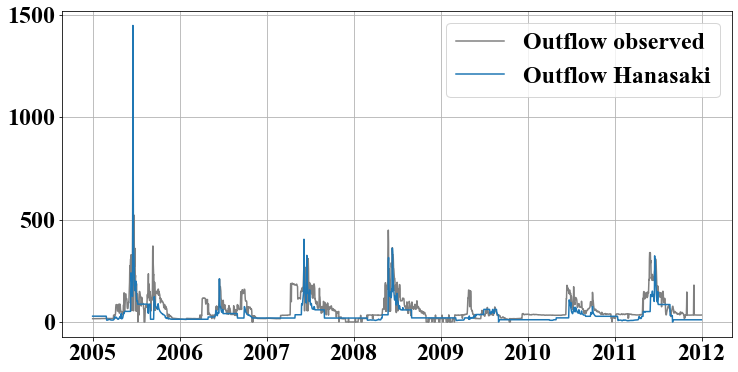

In [66]:
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


df ['outflow_modelled'] = O_time_series

fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(df.outflow, color='gray', label = "Outflow observed")
plt.plot(df.outflow_modelled, label = "Outflow Hanasaki")

plt.legend()
plt.grid()


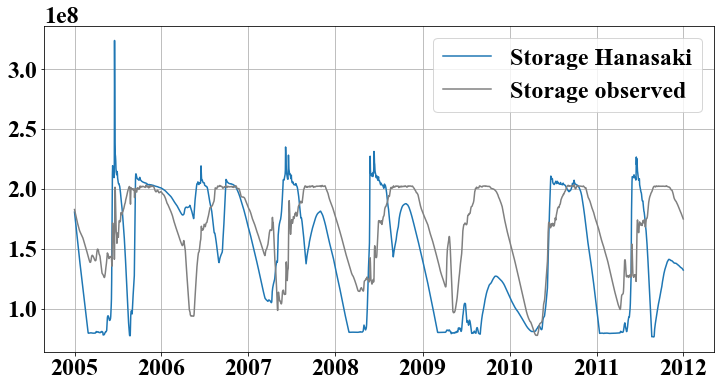

In [67]:
df ['S_modelled'] = S_time_series

fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(df.S_modelled, label = "Storage Hanasaki")
plt.plot(df.stoobs, color='gray', label = "Storage observed")
plt.legend()
plt.grid()


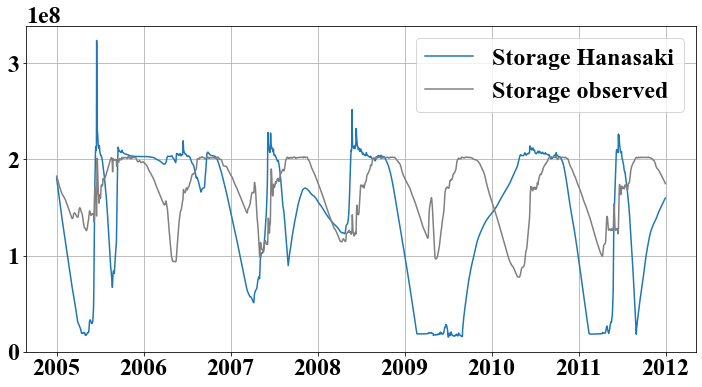

In [59]:
df ['S_modelled'] = S_time_series

fig, axs = plt.subplots(1,1,figsize=(12,6))

plt.plot(df.S_modelled, label = "Storage Hanasaki")
plt.plot(df.stoobs, color='gray', label = "Storage observed")
plt.legend()
plt.grid()


In [60]:
Par_I_month = np.array([9, 9,10,18.64,58,132,59,41,42,27,12,10]) # inflow 12 timesteps for each month starting from january


<AxesSubplot:xlabel='timed'>

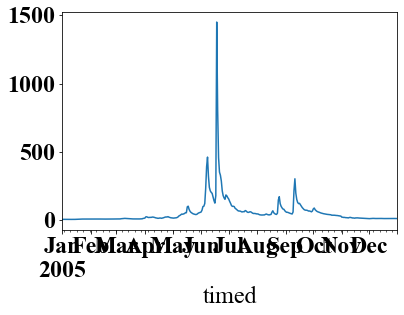

In [22]:
inflow[0:365].plot()

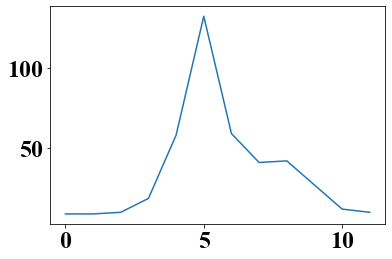

In [23]:
plt.plot(Par_I_month)

In [33]:
df

,timed,stoobs,inflow,outflow,Unnamed: 4,demand
timed,,,,,,
2005-01-01,01-Jan-2005,1.827041e+08,3.620,16.0936,NaN,0
2005-01-02,02-Jan-2005,1.818813e+08,6.362,16.0886,NaN,0
2005-01-03,03-Jan-2005,1.810601e+08,6.402,16.0368,NaN,0
2005-01-04,04-Jan-2005,1.802089e+08,6.404,16.0583,NaN,0
2005-01-05,05-Jan-2005,1.792809e+08,6.272,16.0648,NaN,0
...,...,...,...,...,...,...
2011-12-27,27-Dec-2011,1.771340e+08,7.950,33.7080,NaN,0
2011-12-28,28-Dec-2011,1.766342e+08,7.630,33.7357,NaN,0
2011-12-29,29-Dec-2011,1.760414e+08,7.780,34.0930,NaN,0
